# Deep mutational scanning of Perth/2009 (H3N2) HA

## Overview

We performed deep mutational scanning of **hemagglutinin (HA)** from the **A/Perth/16/2009(H3N2)** influenza virus strain. This is analysis of the data generated from the DMS experiments using the [`dms_tools2`](https://github.com/jbloomlab/dms_tools2) software.

## Experimental summary

The goal of these experiments was to measure the effect of all single amino-acid mutations to HA on viral growth in cell culture. We created triplicate codon-mutant libraries of the Perth/2009 H3 HA, rescued virus libraries using the helper virus approach described in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155), and passaged the generated mutant virus libraries at low multiplicity of infection (MOI) in cell culture to select for functional variants of HA.

For each library, there is a _mutDNA-#_ sample representing the plasmid mutant library, and a _mutvirus-#_ sample representing the mutant viruses after passaging. Note that library 3 was passaged in technical replicate, so there are two _mutvirus_ samples (_3-1_ and _3-2_) for library 3. There is also a single set of wild-type controls for the unmutated plasmid and the corresponding virus, referred to as _wtDNA_ and _wtvirus_.

As described previously, all of the plasmid and virus samples were deep sequenced using a barcoded-subamplicon sequencing approach to reduce the standard Illumina sequencing error rate.

## Goals

In this analysis, we will try to achieve the following goals:
1. Infer the site-specific amino-acid preferences for H3 and use these preferences to improve the phylogenetic fit of natural H3 sequences
2. Investigate the extent of mutational shifts between two diverged HA homologs

## Import modules, define directories

In [1]:
import os
import re
import glob
import itertools
import random
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import joypy
import statsmodels.stats.multitest
from collections import defaultdict

import dms_tools2
import dms_tools2.sra
import dms_tools2.plot
import dms_tools2.prefs
import dms_tools2.compareprefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
# from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

inputdir = './data/'
resultsdir = './results/'
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
prefsdir = os.path.join(resultsdir, 'preferences/')
renumberedprefsdir = os.path.join(resultsdir, 'H3renumberedprefs/')
phydmsdir = os.path.join(resultsdir, 'phydms_analysis/')
logodir = os.path.join(resultsdir, 'logoplots/')
WSNprefsdir = os.path.join(resultsdir, 'WSNpreferences/')
prefsdistdir = os.path.join(resultsdir, 'prefsdist/')
plotsdir = os.path.join(resultsdir, 'plots/')

no display found. Using non-interactive Agg backend


/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/app/python3/3.4.1/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


Using dms_tools2 version 2.2.0


# Section 1: Infer H3 site-specific amino-acid preferences

## Define the samples

Here we will create a `pandas` dataframe to define the samples with the following information:
1. The **name** of each sample.
2. The SRA run accession for the deep sequencing data.

In [2]:
samples = pd.DataFrame.from_records(
        [('mutDNA-1', 'SRR6364210'),
         ('mutDNA-2', 'SRR6364209'),
         ('mutDNA-3', 'SRR6364212'),
         ('mutvirus-1', 'SRR6364216'),
         ('mutvirus-2', 'SRR6364215'),
         ('mutvirus-3-1', 'SRR6364211'),
         ('mutvirus-3-2', 'SRR6364208'),
         ('wtDNA', 'SRR6364214'),
         ('wtvirus', 'SRR6364213')],
        columns=['name', 'run']
        )

## Download `FASTQ` files from the SRA

All of the FASTQ files are on the Sequence Read Archive (SRA) under the run numbers listed in the `samples` dataframe defined above. To download these files, we just pass that dataframe to the [dms_tools2.sra.fastqFromSRA](https://jbloomlab.github.io/dms_tools2/dms_tools2.sra.html#dms_tools2.sra.fastqFromSRA) function. Note that this requires the `fastq-dump` and `aspera` programs to be installed on the computer you are using at the specified paths.

In [3]:
print('Downloading FASTQ files from the SRA...')
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        overwrite={'no':True, 'yes':False}[use_existing],
        no_downloads=True,
        )
print('Completed download of FASTQ files from the SRA')

print('Here are the names of the downloaded files now found in {0}'.format(fastqdir))
display(HTML(samples.to_html(index=False)))

Completed download of FASTQ files from the SRA
Here are the names of the downloaded files now found in ./results/FASTQ_files/


name,run,R1,R2
mutDNA-1,SRR6364210,mutDNA-1_R1.fastq.gz,mutDNA-1_R2.fastq.gz
mutDNA-2,SRR6364209,mutDNA-2_R1.fastq.gz,mutDNA-2_R2.fastq.gz
mutDNA-3,SRR6364212,mutDNA-3_R1.fastq.gz,mutDNA-3_R2.fastq.gz
mutvirus-1,SRR6364216,mutvirus-1_R1.fastq.gz,mutvirus-1_R2.fastq.gz
mutvirus-2,SRR6364215,mutvirus-2_R1.fastq.gz,mutvirus-2_R2.fastq.gz
mutvirus-3-1,SRR6364211,mutvirus-3-1_R1.fastq.gz,mutvirus-3-1_R2.fastq.gz
mutvirus-3-2,SRR6364208,mutvirus-3-2_R1.fastq.gz,mutvirus-3-2_R2.fastq.gz
wtDNA,SRR6364214,wtDNA_R1.fastq.gz,wtDNA_R2.fastq.gz
wtvirus,SRR6364213,wtvirus_R1.fastq.gz,wtvirus_R2.fastq.gz


## Align deep sequencing data and count mutations

We have employed a barcoded-subamplicon sequencing approach to deep sequence the samples to high accuracy. We will now analyze the sequence data using the `dms2_batch_bcsubamp` program.

In [4]:
# Reference coding sequence of Perth/2009 HA; from plasmid #1535 pICR2-Perth09-HA
refseq = './data/Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 161 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts//mutDNA-1_codoncounts.csv
./results/codoncounts//mutDNA-2_codoncounts.csv
./results/codoncounts//mutDNA-3_codoncounts.csv
./results/codoncounts//mutvirus-1_codoncounts.csv
./results/codoncounts//mutvirus-2_codoncounts.csv
./results/codoncounts//mutvirus-3-1_codoncounts.csv
./results/codoncounts//mutvirus-3-2_codoncounts.csv
./results/codoncounts//wtDNA_codoncounts.csv
./results/codoncounts//wtvirus_codoncounts.csv


In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')

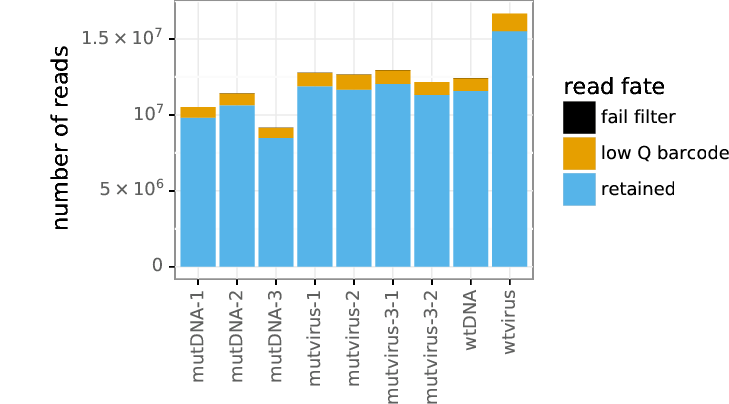

In [7]:
showPDF(countsplotprefix + '_readstats.pdf', width=500)

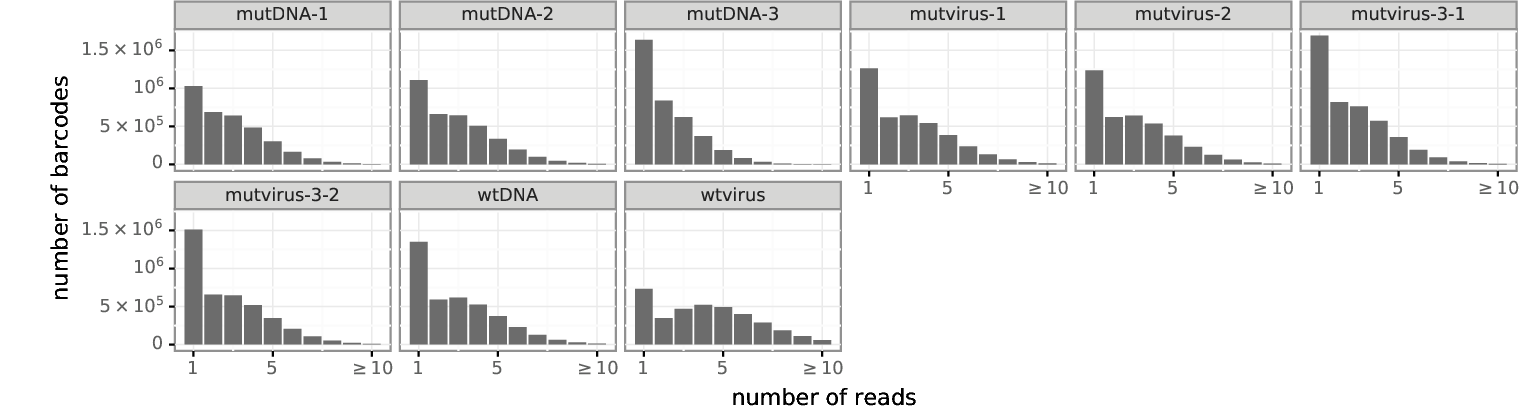

In [8]:
showPDF(countsplotprefix + '_readsperbc.pdf')

Most of the samples appear to have good sequencing depth, although mutDNA-3, mutvirus-3-1, and mutvirus-3-2 look a bit undersequenced.

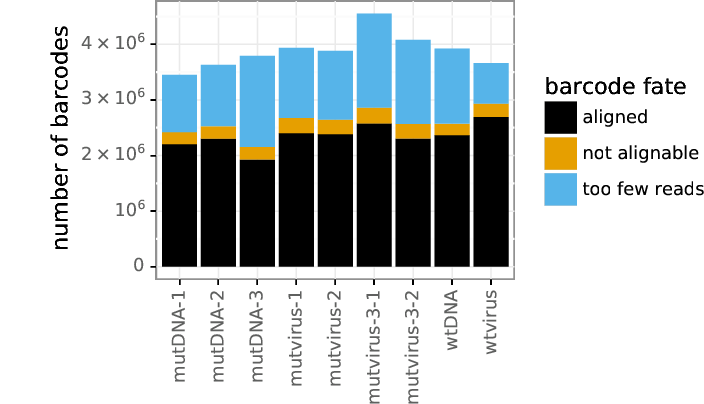

In [9]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

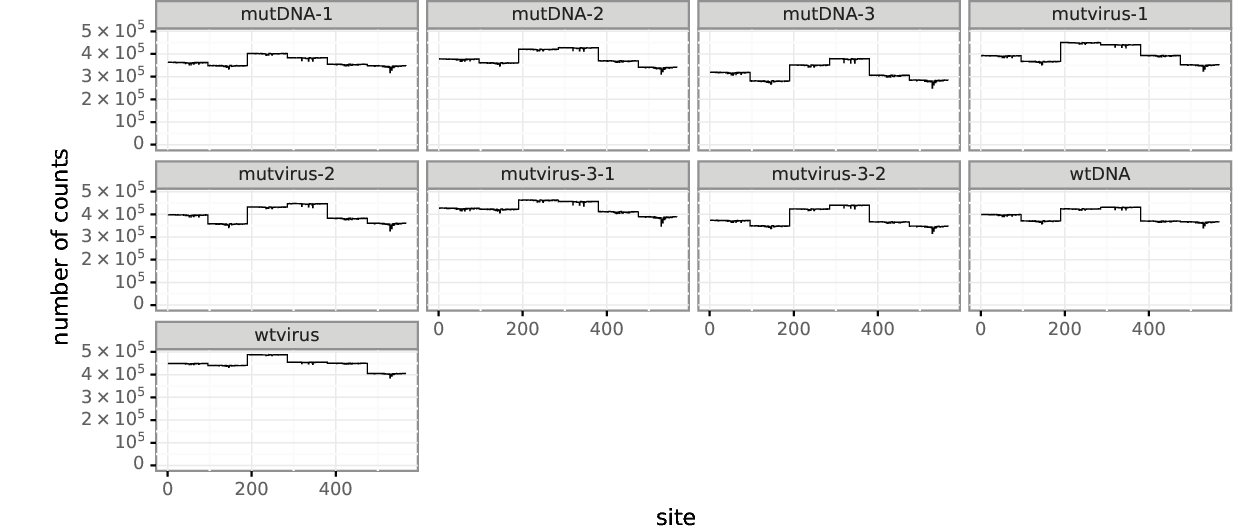

In [10]:
showPDF(countsplotprefix + '_depth.pdf')

Sequencing depth across the HA gene also appears even across all of the samples.

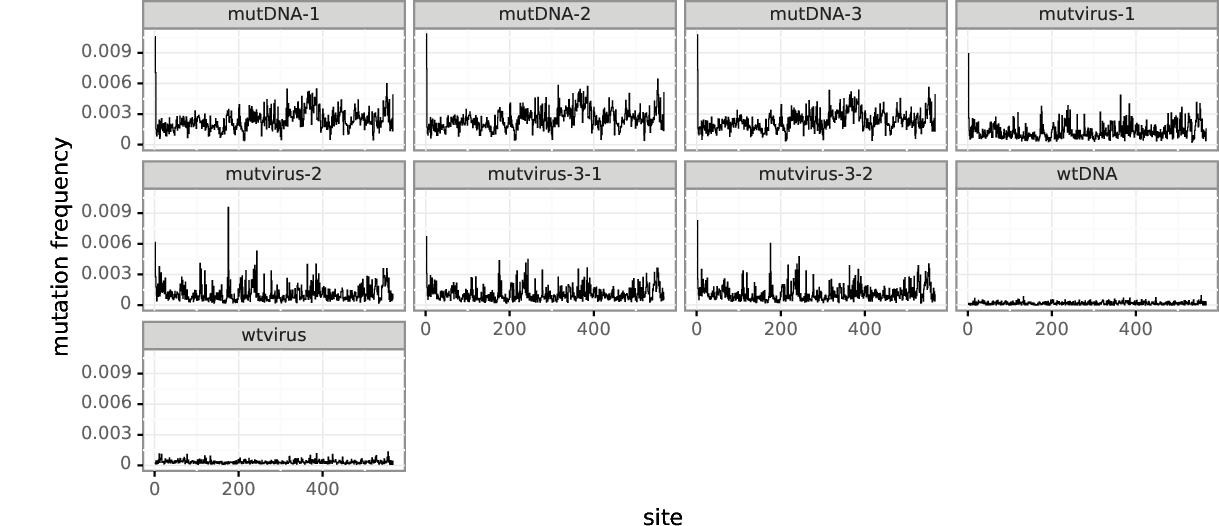

In [11]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The mutation frequencies are highest in the mutDNA samples and lowest in the wtDNA and wtvirus samples. There is a spike in mutation frequency at what appears to be the first codon in each of the three mutDNA samples as well as the mutvirus samples. However, close examination of the mutations in the first codon does not reveal anything too aberrant, and this high mutation frequency may be due to biases in codon mutagenesis.

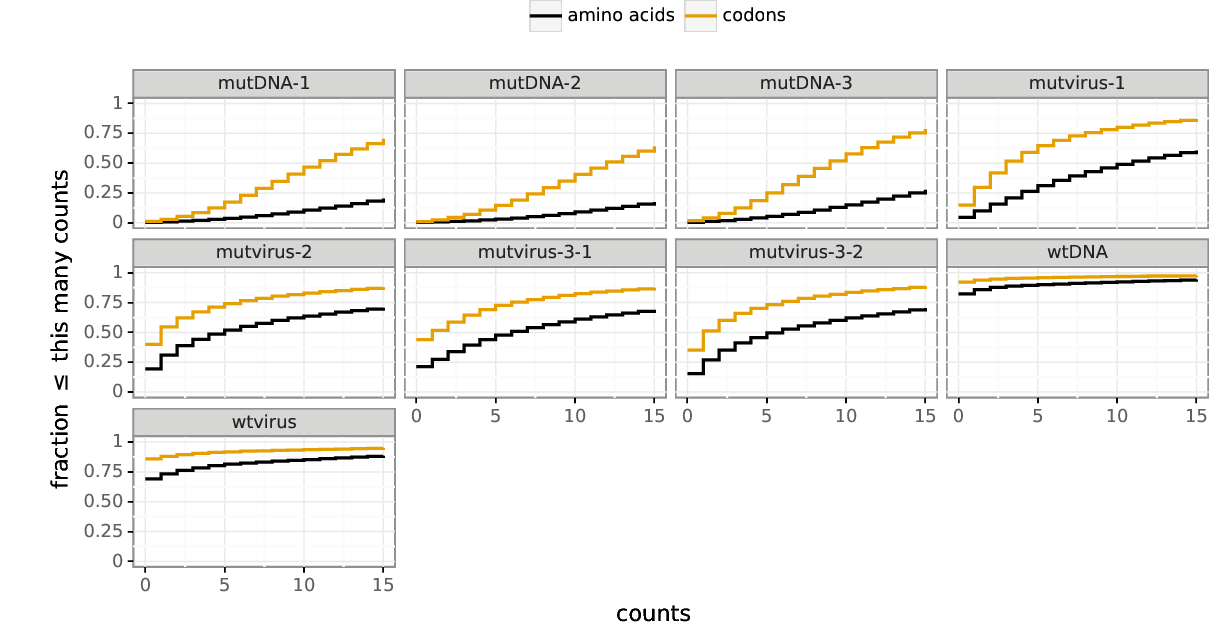

In [12]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

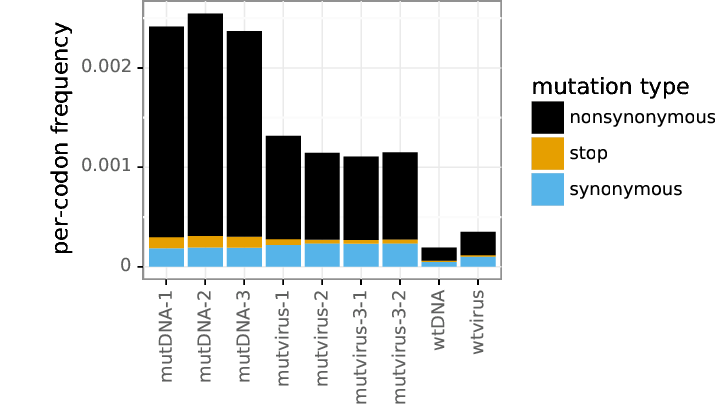

In [13]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

In [14]:
codonmuttypes = pd.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA-1,0.002118,0.000112,0.000186
mutDNA-2,0.002237,0.000117,0.000193
mutDNA-3,0.002068,0.000112,0.000191
mutvirus-1,0.001039,0.000059,0.000219
mutvirus-2,0.000875,0.000036,0.000235
mutvirus-3-1,0.000838,0.000039,0.000232
mutvirus-3-2,0.000876,0.000040,0.000235
wtDNA,0.000130,0.000015,0.000047
wtvirus,0.000233,0.000015,0.000102


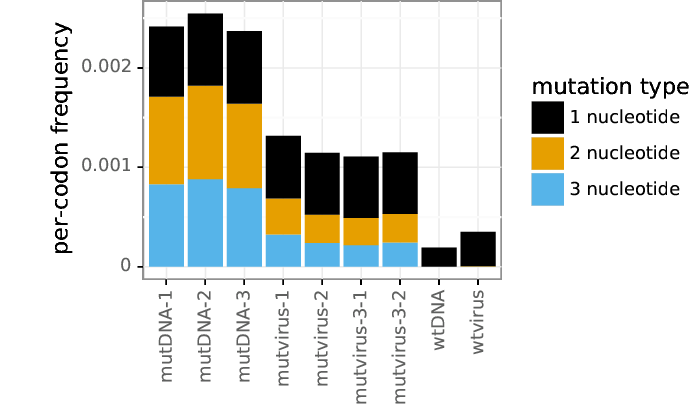

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

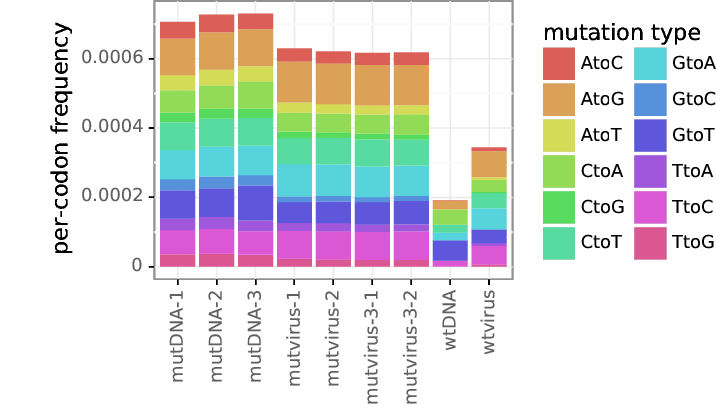

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=500)

# Infer the site-specific amino-acid preferences

In [6]:
# create batch file for dms2_batch_prefs
prefsbatch = pd.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'mutDNA-1', 'mutvirus-1', 'wtDNA', 'wtvirus'),
              ('replicate-2', 'mutDNA-2', 'mutvirus-2', 'wtDNA', 'wtvirus'),
              ('replicate-3-1', 'mutDNA-3', 'mutvirus-3-1', 'wtDNA', 'wtvirus'), 
              ('replicate-3-2', 'mutDNA-3', 'mutvirus-3-2', 'wtDNA', 'wtvirus')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
replicate-1,mutDNA-1,mutvirus-1,wtDNA,wtvirus
replicate-2,mutDNA-2,mutvirus-2,wtDNA,wtvirus
replicate-3-1,mutDNA-3,mutvirus-3-1,wtDNA,wtvirus
replicate-3-2,mutDNA-3,mutvirus-3-2,wtDNA,wtvirus


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In [7]:
!ls {prefsdir}/*_prefs.csv

./results/preferences//renum_replicate-1_prefs.csv
./results/preferences//renum_replicate-2_prefs.csv
./results/preferences//renum_replicate-3_prefs.csv
./results/preferences//replicate-1_prefs.csv
./results/preferences//replicate-2_prefs.csv
./results/preferences//replicate-3-1_prefs.csv
./results/preferences//replicate-3-2_prefs.csv
./results/preferences//replicate-3_prefs.csv


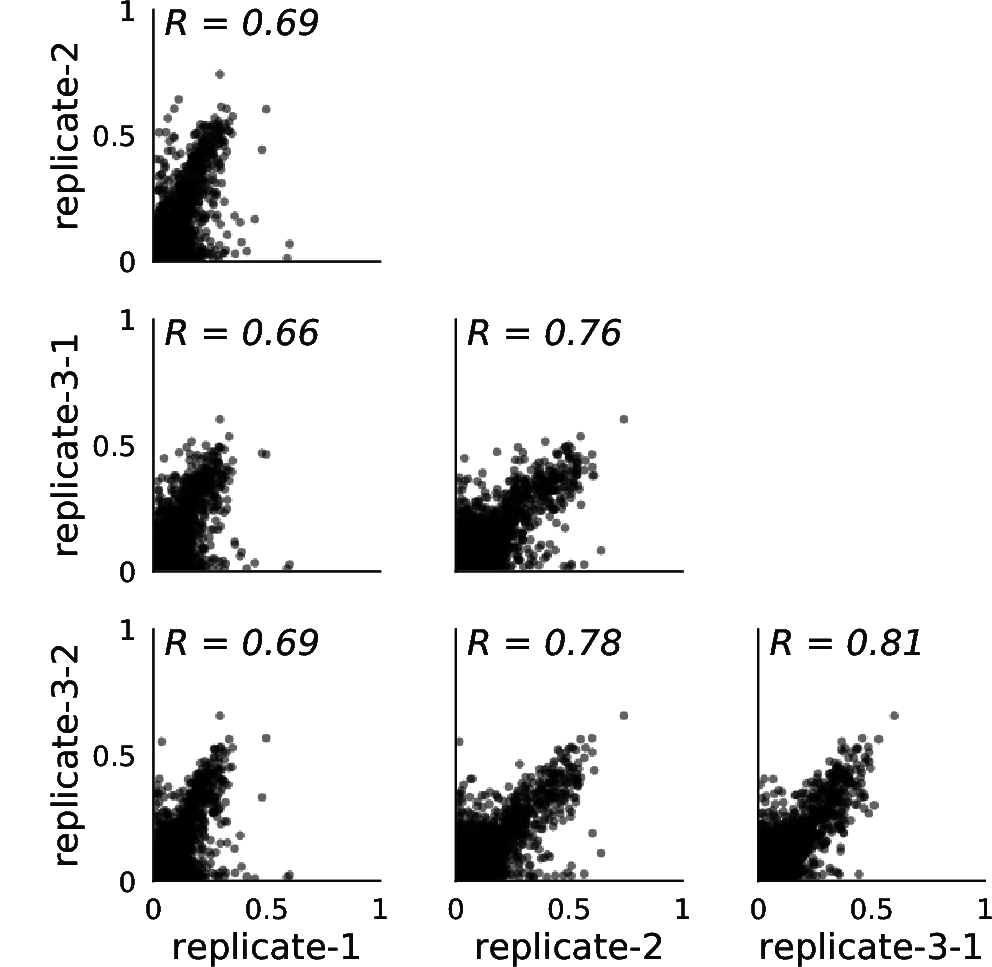

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width=300)

The Pearson's $R$ shows that the biological replicates are fairly reproducible. In addition, the correlation between the two technical replicates (3-1 and 3-2) is only slightly higher than that between biological replicates, which indicates that bottlenecking of variants _after_ helper-virus rescue of the viral library contribute to most of the experimental noise observed among replicates.

# Renumber preferences to H3 numbering and average across replicates

We will now renumber the preferences from sequential (1, 2, ... starting from the initial Met) to H3 numbering. 
The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. 
This numbering scheme is based on an alignment to a PDB structure for an H3 HA [4HMG](https://www.rcsb.org/pdb/explore/explore.do?structureId=4HMG). 
We will use:
1. The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers into the H3 numbering scheme
2. The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `H3renumberedprefs` directory and will possess the same names as the original preferences files created from `dms2_batch_bcsuabmp` above.

Before renumbering, we must first average across the two technical replicates of replicate 3. 
After taking the average of the technical replicates, we will renumber the preferences files.
Finally, we will average across the biological replicates.

In [8]:
# Average across the two technical replicates of replicate 3
rep3df = dms_tools2.prefs.avgPrefs(glob.glob('{0}/replicate-3-*_prefs.csv'.format(prefsdir)))
rep3df.to_csv('{0}/replicate-3_prefs.csv'.format(prefsdir), index=False)

In [9]:
renumberfile = './data/H3renumbering_scheme.csv'

# preferences files to renumber
prefsfiles = glob.glob('{0}/replicate-*_prefs.csv'.format(prefsdir))

dms_tools2.utils.renumberSites(renumberfile, prefsfiles, missing='drop', 
        outdir=renumberedprefsdir)

In [10]:
# Average across the three biological replicates
avgprefsdf = dms_tools2.prefs.avgPrefs(glob.glob('{0}/replicate-?_prefs.csv'.format(renumberedprefsdir)))
avgprefsdf.to_csv('{0}/summary_avgprefs.csv'.format(renumberedprefsdir), index=False)

seqnum_avgprefsdf = dms_tools2.prefs.avgPrefs(glob.glob('{0}/replicate-?_prefs.csv'.format(prefsdir)))
seqnum_avgprefsdf.to_csv('{0}/summary_avgprefs.csv'.format(prefsdir), index = False)

avgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs.csv')
avgprefs_seqnum = os.path.join(prefsdir, 'summary_avgprefs.csv')

# Fit preferences to the evolution of natural H3 sequences

We will now use the preferences inferred above to describe the natural evolution of human H3N2 and swine H3N2 influenza viruses.

In [11]:
print("Using the following version of phydms:")
!phydms -v

raxmlpath = 'raxmlHPC-SSE3'
hosts = ['human', 'swine']

for host in hosts:
    alignment = './data/H3_{0}_alignment.fa'.format(host)
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    if use_existing == 'yes' and os.path.isfile(modelcomparison):
        print('Results of phydms analysis for {0} alignment already exist.'.format(host))
    else:
        print('Running phydms_comprehensive...')
        outprefix = '{0}/{1}'.format(phydmsdir, host)
        log = !phydms_comprehensive {outprefix} {alignment} {avgprefs_seqnum} --raxml {raxmlpath} --omegabysite
        print('Analysis for {0} alignment complete.'.format(host))

Using the following version of phydms:
phydms 2.2.0
Results of phydms analysis for human alignment already exist.
Results of phydms analysis for swine alignment already exist.


In [29]:
print('This is the model comparison using a human alignment:')
modelcomparison = '{0}/human_modelcomparison.md'.format(phydmsdir, host)
display(Markdown(modelcomparison))

This is the model comparison using a human alignment:


| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -8441.16      | 6       | beta=2.47, kappa=5.76, omega=0.91             |
| YNGKP_M5                        | 2162.40  | -9516.36      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_summary_avgprefs | 2500.72  | -9691.52      | 6       | beta=0.67, kappa=5.58, omega=0.32             |
| YNGKP_M0                        | 2604.26  | -9738.29      | 11      | kappa=5.05, omega=0.31                        |

The results above show that the ExpCM using the averaged preferences performs substantially better than traditional codon substitution models in describing the evolution of human H3N2 viruses in nature. 

The ExpCM has an $\omega$ value close to 1 whereas traditional codon substitution models have an $\omega <<$ 1, suggesting that our experiments capture amino-acid constraints on HA.

In addition, the ExpCM fit a stringency parameter $\beta$ that is > 1, indicating that natural selection prefers the same amino acids as in our experiments, but with greater stringency.
We can use this stringency parameter to re-scale our averaged preferences (as described in [Hilton et al 2017](https://peerj.com/articles/3657/)), and we will use these averaged and re-scaled preferences for all downstream analyses below.

## Display preferences as a rescaled logoplot

I will use the rescaling parameter ( $\beta$ ) from `phydms_comprehensive` to create logoplots of rescaled preferences.
First, I will read in the beta values from the `ExpCM *_modelparams.txt` file.

In [13]:
params_file = open('{0}/human_ExpCM_summary_avgprefs_modelparams.txt'.format(phydmsdir), 'r')
params_lst = [line.rstrip() for line in params_file.readlines()]
params_file.close()
beta = float([line for line in params_lst if 'beta' in line][0][7:])
print ('The beta parameter for the ExpCM for the averaged preferences = {0}'.format(beta))

The beta parameter for the ExpCM for the averaged preferences = 2.46635


### Re-scale the preferences

In [15]:
unscaled_prefsdf = pd.read_csv(avgprefs)
rescaled_prefsdf = dms_tools2.prefs.rescalePrefs(unscaled_prefsdf, beta)

rescaledavgprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled.csv')
rescaled_prefsdf.to_csv(rescaledavgprefs, index=False)

In [16]:
# Domain sites file
domainfile = './data/domains.csv'

# Epitope sites file
epitopefile = './data/wolf_epitope_sites.csv'

In [17]:
seq_wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pd.read_csv(os.path.join(countsdir, 'wtDNA_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(seq_wtoverlayfile, index=False)

wtoverlayfile = os.path.join(renumberedprefsdir, 'wildtypeoverlayfile.csv')

dms_tools2.utils.renumberSites(renumberfile, [seq_wtoverlayfile], missing='drop', outdir=renumberedprefsdir)

Next, I will use the stringency parameters ( $\beta$ ) to make rescaled logoplots by specifying the `'--stringency'` argument.

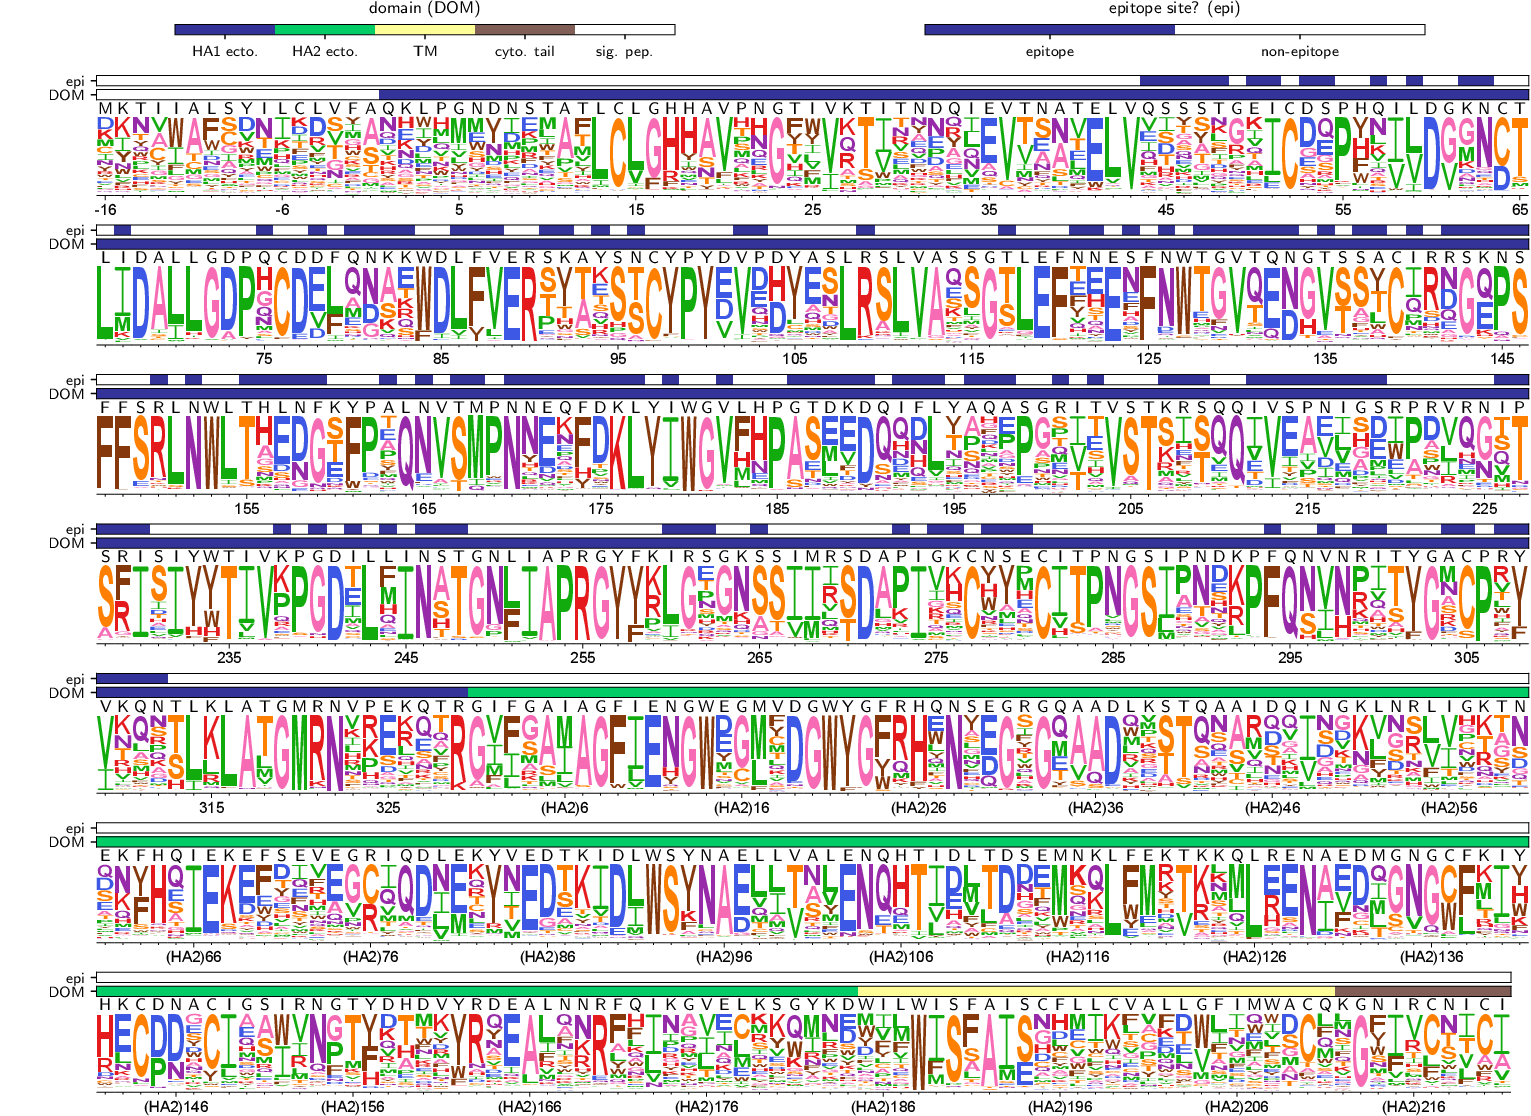

In [18]:
rescaledlogoname = 'rescaled-avgprefs'

log = !dms2_logoplot \
        --prefs {rescaledavgprefs} \
        --name {rescaledlogoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {domainfile} DOM "domain" \
        --overlay3 {epitopefile} epi "epitope site?" \
        --overlaycolormap "terrain" \
        --nperline 81 \
        --use_existing no
        
rescaledlogoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)

## Calculate the site entropy and write to a new preferences file

In [19]:
entropy_prefsdf = dms_tools2.prefs.prefsEntropy(rescaled_prefsdf, dms_tools2.AAS)

entropyprefs = os.path.join(renumberedprefsdir, 'summary_avgprefs_rescaled_entropies.csv')
entropy_prefsdf.to_csv(entropyprefs, index=False)

# Section 3: Compare the preferences between the HA homologs

In this section, we will compare the preferences between the two HA homologs: Perth/2009 H3 and WSN/1933 H1. 
The WSN/1933 HA preferences were previously measured in [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155). The HIV Env preferences were previously measured in [Haddox et al (2017)](https://www.biorxiv.org/content/early/2017/12/16/235630).

First, we need to renumber and rescale the preferences so that we can make comparisons between the two HA homologs. I aligned the Perth/2009 H3 and WSN/1933 H1 amino-acid sequences using `mafft`. I will renumber each of the preferences file based on the alignment and remove sites that do not align. The renumbering files are provided in the [`./data/`](./data/) directory as `[homolog]_compareprefs_renumber.csv`, where `<[homolog]>` is Perth2009 or WSN.

In [35]:
# the homologs that we are examining
homologs = ['Perth', 'WSN']

# Renumber unscaled preferences
Perth_renumbfile = './data/Perth2009_compareprefs_renumber.csv'
dms_tools2.utils.renumberSites(Perth_renumbfile, 
                               sorted(glob.glob('{0}/replicate-?_prefs.csv'.format(prefsdir))), 
                               missing='drop', 
                               outprefix='renum_')

WSN_renumbfile = './data/WSN_compareprefs_renumber.csv'
dms_tools2.utils.renumberSites(WSN_renumbfile, 
                               sorted(glob.glob('{0}/WSN_replicate-?_prefs.csv'.format(inputdir))), 
                               missing='drop', 
                               outfiles=['{0}/renum_replicate-{1}_prefs.csv'.format(WSNprefsdir, x) for x in range(1,4)])

# Rescale WSN HA preferences
WSN_stringency = 2.05
for r in [1, 2, 3]:
    unscaled = '{0}/renum_replicate-{1}_prefs.csv'.format(WSNprefsdir, r)
    rescaled = os.path.join(prefsdistdir, 'WSN_replicate-{0}_prefs_rescaled.csv'.format(r))
    (dms_tools2.prefs.rescalePrefs(pd.read_csv(unscaled), WSN_stringency)
            .to_csv(rescaled, index=False))
    
# Rescale Perth/2009 HA preferences
for r in [1, 2, 3]:
    unscaled = '{0}/renum_replicate-{1}_prefs.csv'.format(prefsdir, r)
    rescaled = os.path.join(prefsdistdir, 'Perth_replicate-{0}_prefs_rescaled.csv'.format(r))
    (dms_tools2.prefs.rescalePrefs(pd.read_csv(unscaled), beta)
            .to_csv(rescaled, index=False))

### Correlate the Perth/2009 H3 and WSN/1933 H1 preferences

First, we will examine the correlations between Perth/2009 and WSN HA preferences.

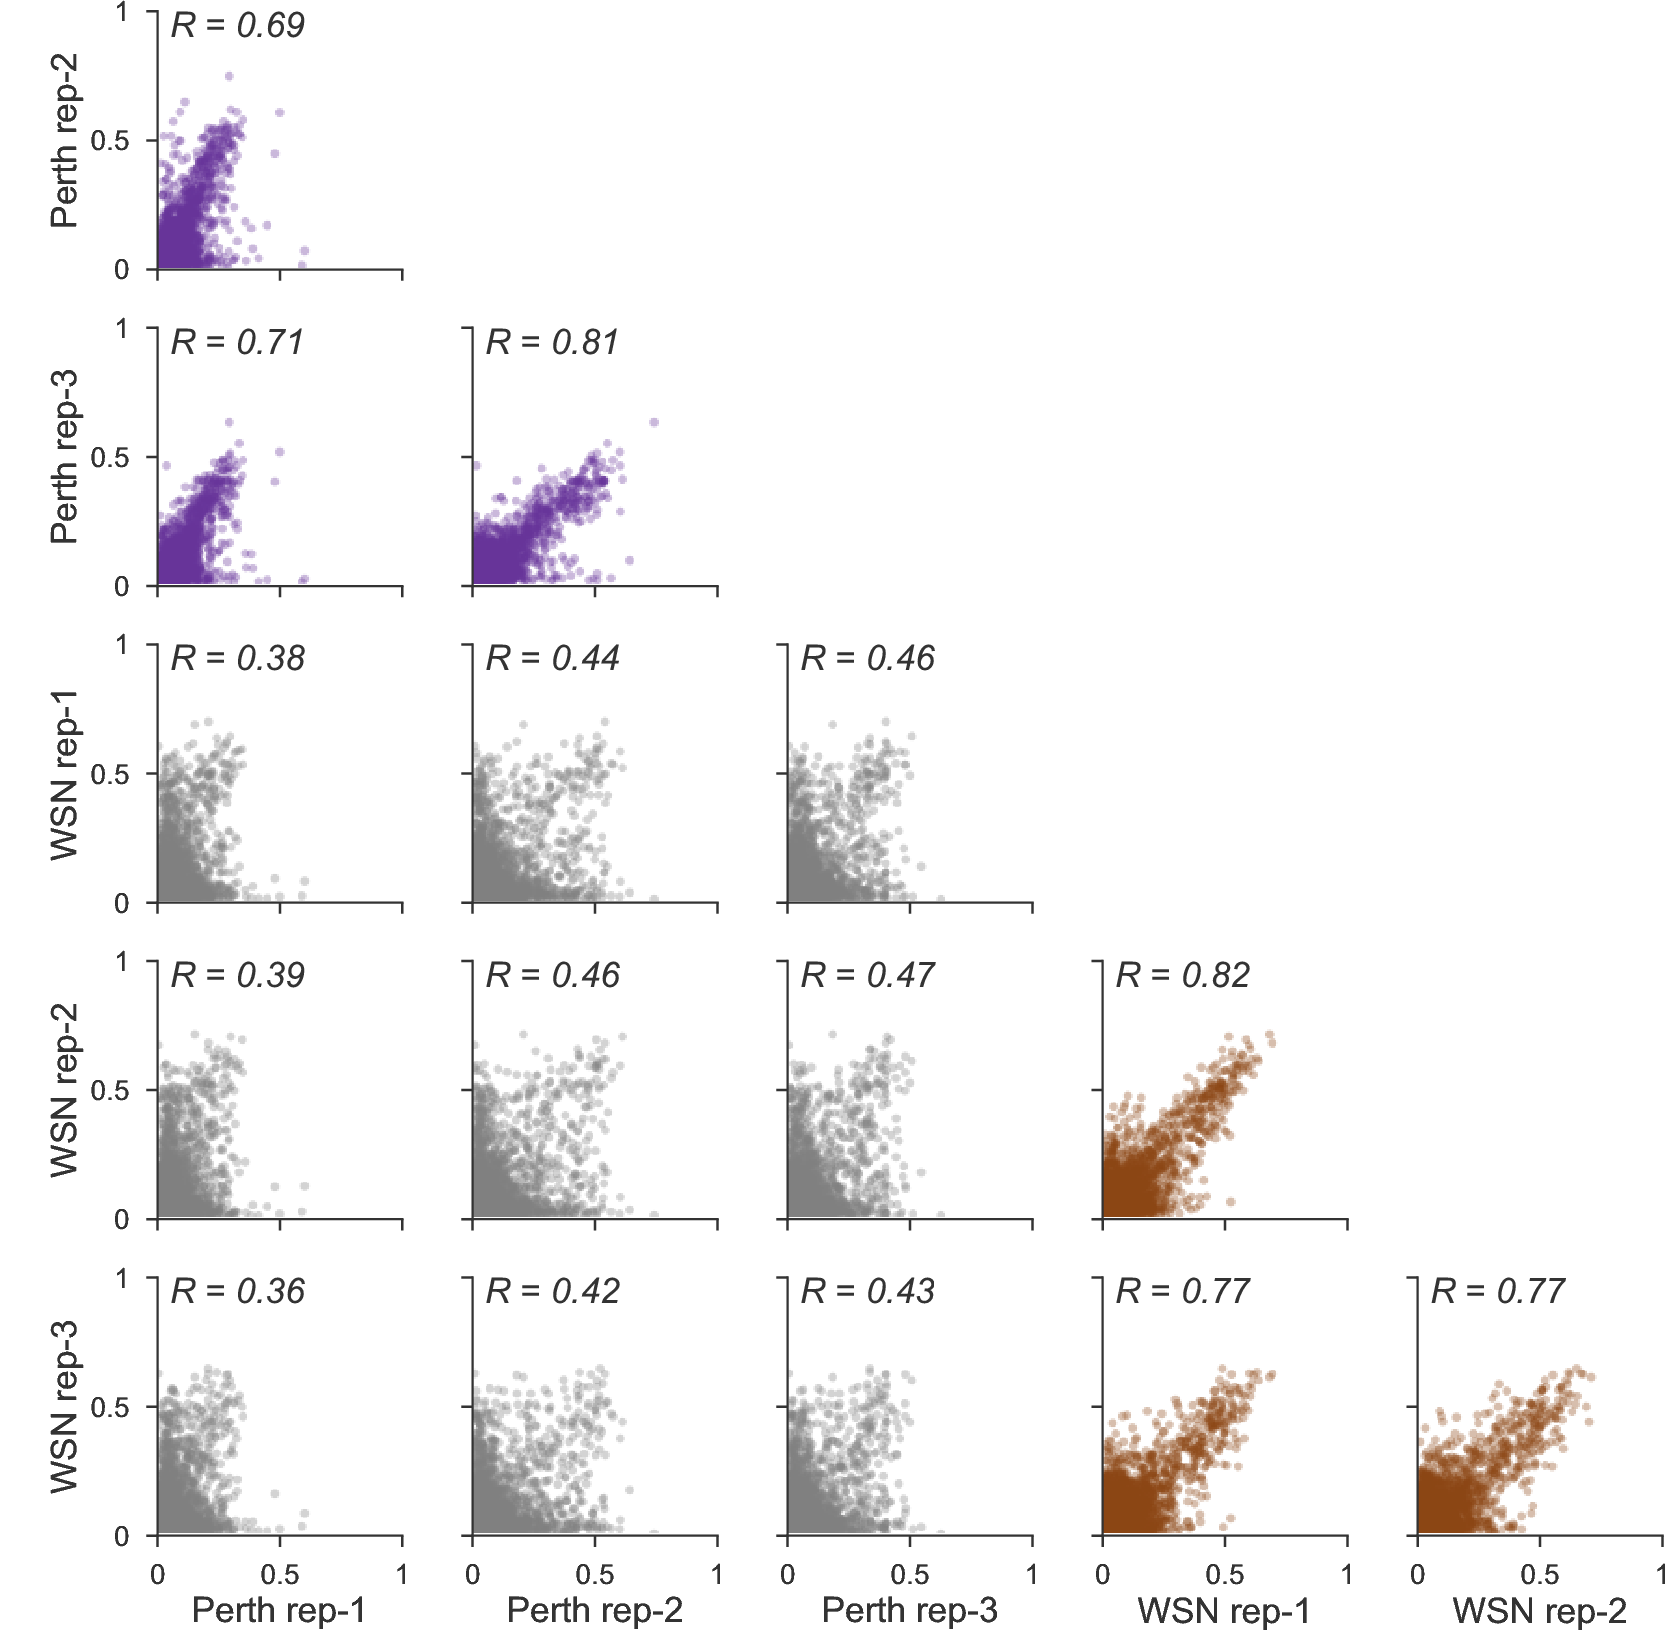

In [36]:
homolog_corrs = os.path.join(prefsdistdir, 'homolog_correlations.pdf')

prefs_names = ['WSN rep-1', 'WSN rep-2', 'WSN rep-3', 
               'Perth rep-1', 'Perth rep-2', 'Perth rep-3']

allHAprefs = glob.glob('{0}/renum_replicate-*_prefs.csv'.format(prefsdir)) \
                + glob.glob('{0}/renum_replicate-*_prefs.csv'.format(WSNprefsdir))

# how to color scatter plots depending on which homologs
# this will break for different numbers of homologs
colors = ['rebeccapurple'] * 3 + ['gray'] * 6 + ['saddlebrown'] + ['gray'] * 3 + ['saddlebrown'] * 2

dms_tools2.plot.plotCorrMatrix(prefs_names, 
                               sorted(allHAprefs), 
                               homolog_corrs, 
                               'prefs', 
                               trim_unshared=True, 
                               colors=colors)

showPDF(homolog_corrs)

### Compute the distances between preferences

In order to quantitatively compare the preferences, we will use the `compareprefs` module of `dms_tools2` to compute $RMSD_{corrected}$ values that allow us to account for experimental noise in the measurements within a given homolog.

In [22]:
# distances between the two HA homologs
assert len(homologs) == 2, "plotting needs to be refactored if > 2 homologs"
prefs1 = glob.glob('{0}/Perth_replicate-*_prefs_rescaled.csv'.format(prefsdistdir))
prefs2 = glob.glob('{0}/WSN_replicate-*_prefs_rescaled.csv'.format(prefsdistdir))

prefsdist = dms_tools2.compareprefs.comparePrefs(prefs1, prefs2)
prefsdistfile = os.path.join(prefsdistdir, '{0}_to_{1}_prefs_dist.csv'.format(*homologs))
prefsdist.to_csv(prefsdistfile, index=False)

# distances for all randomizations of 3 replicates per homolog
rand_dists = []
assert len(prefs1) == len(prefs2) == 3, "code expects 3 replicates / homologs"
for set1 in itertools.combinations(prefs1 + prefs2, 3):
    set2 = [iprefs for iprefs in prefs1 + prefs2 if iprefs not in set1]
    rand_dists += (dms_tools2.compareprefs.comparePrefs(set1, set2)
                      ['RMSDcorrected'].tolist())

# distances from each homolog to BF520 Env prefs
env_prefs = glob.glob('{0}/Env_BF520_replicate-*_prefs_rescaled.csv'.format(inputdir))
ha_env_dist = {}
for (homolog, homologprefs) in zip(homologs, [prefs1, prefs2]):
    ha_env_dist[homolog] = (dms_tools2.compareprefs.comparePrefs(env_prefs, homologprefs)['RMSDcorrected'].tolist())
    
# read in distances for Env homologs
env_dists = (pd.read_csv('./results/prefsdist/BG505_to_BF520_prefs_dist.csv'))['RMSDcorrected'].tolist()

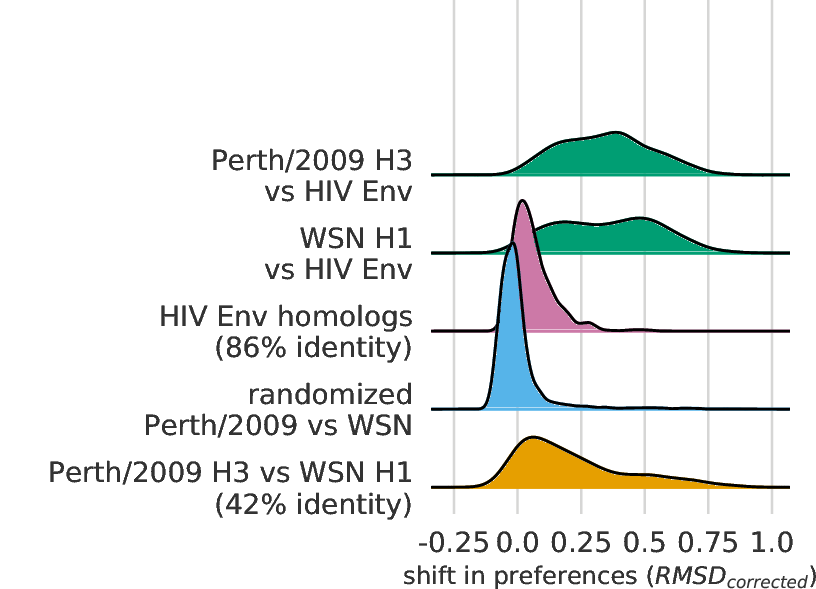

In [23]:
distplot = os.path.join(prefsdistdir, 'distance_distribution.pdf')

actual_dists = prefsdist['RMSDcorrected'].tolist()

# the data to plot
joyplot_data = collections.OrderedDict([
                ('Perth/2009 H3\n vs HIV Env', ha_env_dist[homologs[0]]),
                ('WSN H1\n vs HIV Env', ha_env_dist[homologs[1]]),
                ('HIV Env homologs\n (86% identity)', env_dists),
                ('randomized\n Perth/2009 vs WSN', rand_dists),
                ('Perth/2009 H3 vs WSN H1\n (42% identity)', actual_dists)])
    
# colors for each comparison: same color for the two HA comparisons
cmap = mpl.colors.ListedColormap(["#009E73", "#009E73", "#CC79A7", "#56B4E9", "#E69F00"])

# make the joyplot
joypy.joyplot(joyplot_data,
              grid='x',
              overlap=1,
              linewidth=1.5,
              figsize=(6, 4.8),
              colormap = cmap,
             )
plt.xlabel('shift in preferences ($RMSD_{corrected}$)', size=13)

# save and show
plt.savefig(distplot)
showPDF(distplot, width=600)

In [24]:
# compute P-values
rand_dists = np.array(rand_dists)
actual_dists = sorted(actual_dists, reverse=True)
n = float(len(rand_dists))
pvals = [np.greater_equal(rand_dists, d).sum() / n for d in actual_dists]
assert pvals == sorted(pvals), "pvals should be sorted if actual_dists sorted"

# get minimum distance at which we reject null at FDR of 0.1
fdr = 0.1
reject = statsmodels.stats.multitest.multipletests(
          pvals, alpha=fdr, method='fdr_bh')[0].tolist()
assert any(reject), "no significants sites at FDR, rest of code won't work"
min_dist = actual_dists[reject.index(False) - 1]
print("At FDR of {0}, we consider homolog-to-homolog diffs significant if they "
      "exceed {1:.3f}. There are {2} such sites out of {3} total.".format(
      fdr, min_dist, sum(reject), len(actual_dists)))

At FDR of 0.1, we consider homolog-to-homolog diffs significant if they exceed 0.308. There are 146 such sites out of 552 total.


### Examine mutational shifts at different domains and sites

Now we will examine the extent of mutational shifts in the head vs stalk domains. The demarcation between the head and stalk domains is defined by a disulfide bridge formed by two cysteines at sites 52 and 277 (H3 numbering). 

In addition, based on a multiple sequence alignment of all 18 HA subtypes, there were 94 sites that were absolutely conserved across all the subtypes, so we will look at the distribution of distances for these conserved sites.

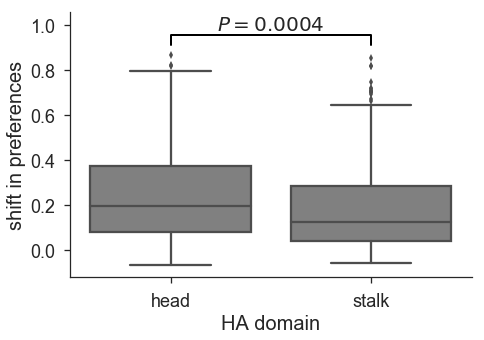

In [31]:
for i, row in prefsdist.iterrows():
    if int(i) in range(59,279):
        prefsdist.set_value(i, 'domain', 'head')
    else:
        prefsdist.set_value(i, 'domain', 'stalk')

# Now plot the shifts in preferences for the two HA domains
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='domain', 
            y='RMSDcorrected', 
            data=prefsdist, 
            order = ['head', 'stalk'],
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('HA domain', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['domain'] == 'head']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['domain'] == 'stalk']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, '$P = {0:.4f}$'.format(p), 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/HAdomains_vs_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()

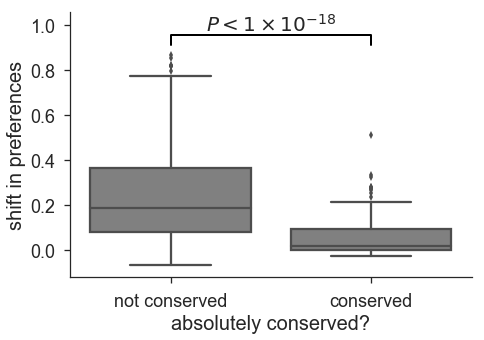

In [32]:
abs_conserved_sites = [s.strip() for s in (open('./data/abs_conserved_sites.txt', 'r')).readlines()]

for i, row in prefsdist.iterrows():
    if str(i+1) in abs_conserved_sites:
        prefsdist.set_value(i, 'abs_conserved', 'conserved')
    else:
        prefsdist.set_value(i, 'abs_conserved', 'not conserved')

# Now plot the shifts in preferences for the two classes
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='abs_conserved', 
            y='RMSDcorrected', 
            data=prefsdist,
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('absolutely conserved?', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['abs_conserved'] == 'conserved']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['abs_conserved'] == 'not conserved']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, r'$P < 1 \times 10^{-18}$', 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/Conserved_vs_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()

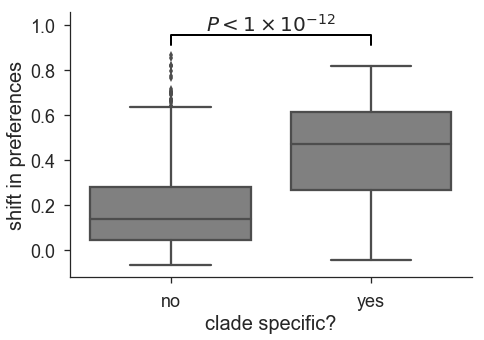

In [33]:
clade_specific_sites = [s.strip() for s in (open('./data/clade_specific_sites.txt', 'r')).readlines()]

for i, row in prefsdist.iterrows():
    if str(i+1) in clade_specific_sites:
        prefsdist.set_value(i, 'clade_specific', 'yes')
    else:
        prefsdist.set_value(i, 'clade_specific', 'no')

# Now plot the shifts in preferences for the two classes
sns.set_style('white')
sns.set_style('ticks')
(fig, ax) = plt.subplots(figsize=(7,5))
sns.boxplot(x='clade_specific', 
            y='RMSDcorrected', 
            data=prefsdist,
            color='gray')

plt.ylabel('shift in preferences', fontsize=20)
plt.xlabel('clade specific?', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Calculate significance
p = scipy.stats.mannwhitneyu(
        prefsdist.loc[prefsdist['clade_specific'] == 'yes']['RMSDcorrected'], 
        prefsdist.loc[prefsdist['clade_specific'] == 'no']['RMSDcorrected']
        )[1]
(x1, x2) = (0, 1)
yextend = 1.05
y = prefsdist.RMSDcorrected.max() * yextend
plt.plot([x1, x1, x2, x2], [y, yextend * y, yextend * y, y], c='black', lw=2)
plt.text((x1 + x2) / 2, y * yextend, r'$P < 1 \times 10^{-12}$', 
         ha='center', va='bottom', size=20)
ax.set_ylim(top=y*(yextend**3))

sns.despine()
plt.tight_layout()
# plt.savefig('{0}/clade_specific_shifts.pdf'.format(prefsdistdir), format='pdf')
plt.show()